## Exploring iSOON's Leaked Docs

Ref: [I-SOON Leak News](https://www.darkreading.com/threat-intelligence/-isoon-contractor-helps-the-prc-hack-foreign-governments-companies)

### Setup Dependencies

In [3]:
import sys
import os
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import rcParams
import spacy
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
from gensim.parsing.preprocessing import remove_stopwords
from pprint import pprint

## Process Unstructured Text

Remove unnecessary stopwords from the given text input.

### Read Chat File

In [4]:
INPUT_FILE_PATH = "leaked_docs/isoon_docs_english.txt"

In [5]:

path = os.path.join(os.getcwd(),INPUT_FILE_PATH)
with open(path,"r") as fh:
        file_data = fh.read()

### Load Stopwords

In [6]:
stopwords_list = []
spacy_en_model = spacy.load('en_core_web_sm')
nltk.download("stopwords")

spacy_stopwords = list(spacy_en_model.Defaults.stop_words)
nltk_stopwords = stopwords.words("english")
gensim_stopwords = list(gensim_stopwords)

[nltk_data] Downloading package stopwords to /home/bikram-
[nltk_data]     xps/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
stopwords_list.extend(spacy_stopwords + nltk_stopwords + gensim_stopwords)
stopwords_list.extend([
    'td',
    'tr',
    'NULL'
])


In [8]:
# Remove stopwords from given text
file_data = remove_stopwords(file_data)

## Generate Wordcloud

In [9]:
MAX_WORDS_IN_WORDCLOUD = 500
WORDCLOUD_BACKGROUND_COLOR = "black"

In [10]:
#call the wordcloud Constructor 
WC = WordCloud(
    stopwords=stopwords_list,
    max_words=MAX_WORDS_IN_WORDCLOUD,
    background_color=WORDCLOUD_BACKGROUND_COLOR, 
    width=1800, 
    height=800, 
    collocations=False).generate(file_data)

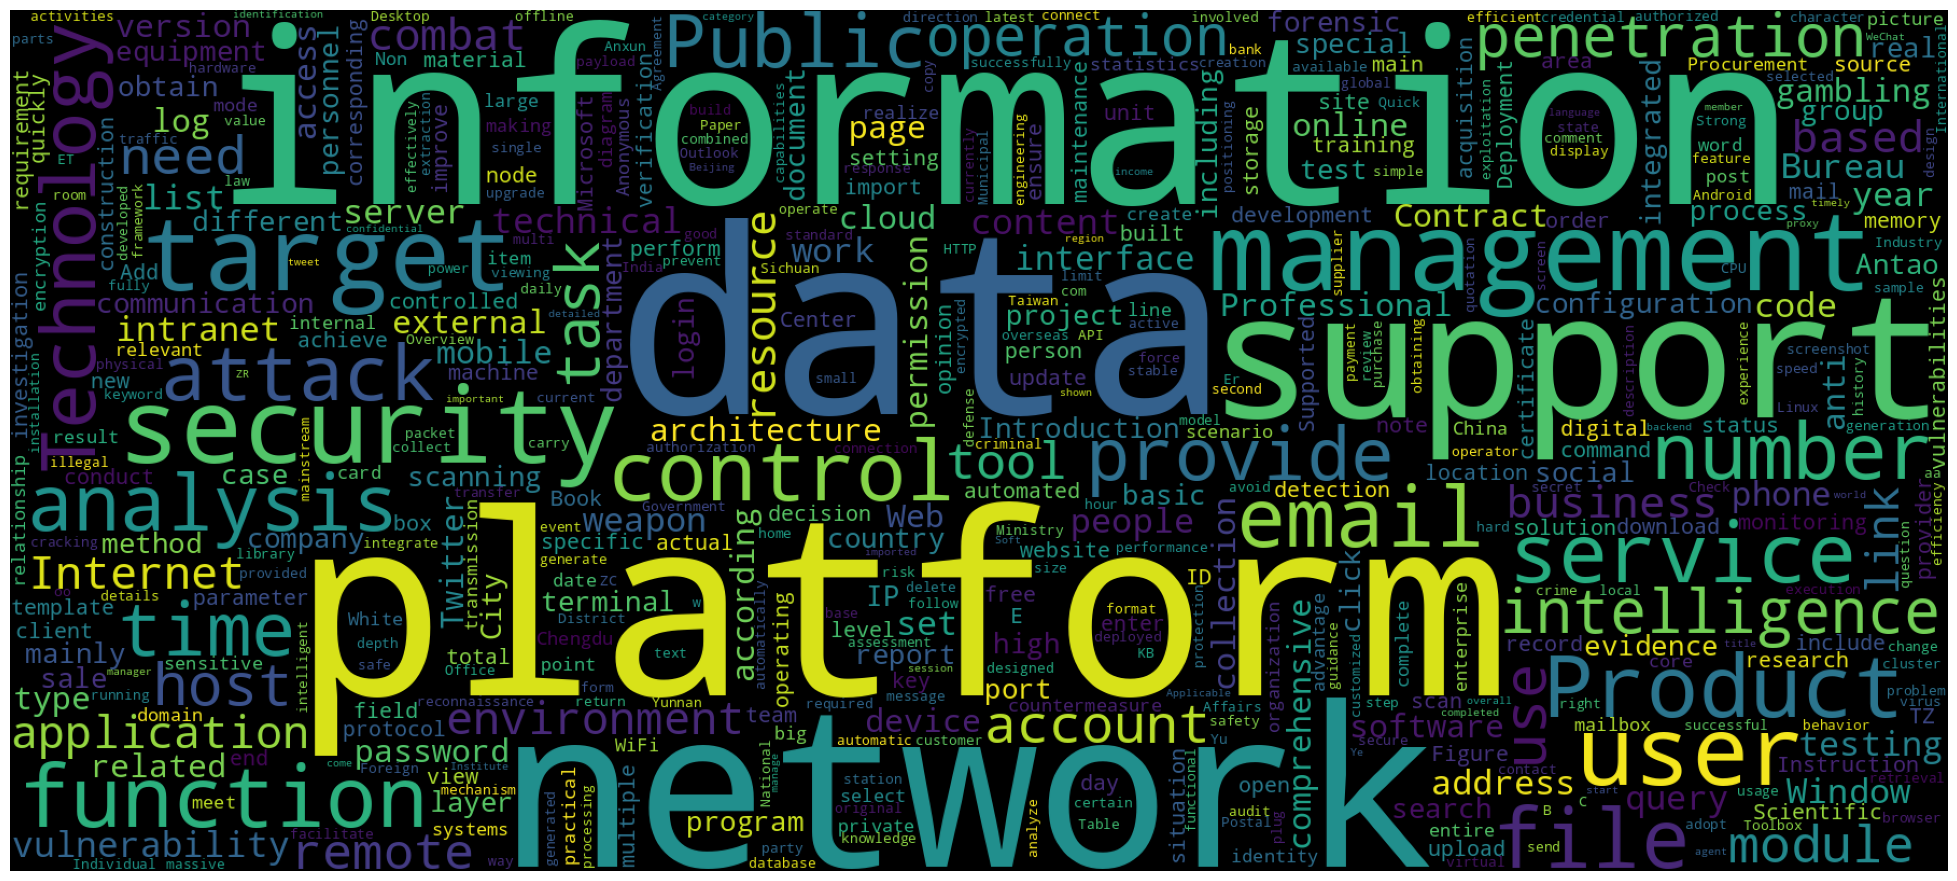

In [11]:
plt.figure(figsize=(25,15), facecolor='white')
plt.imshow(WC)
plt.axis("off")
plt.show()

## Extract Interesting Strings

### Extract observables/selectors with `ioc-finder`

In [12]:
from ioc_finder import find_iocs

ALLOWED_IOC_TYPES = [
    # "asns",
    # "attack_mitigations",
    # "attack_tactics",
    # "attack_techniques",
    # "authentihashes",
    "bitcoin_addresses",
    # "cves",
    "domains",
    "email_addresses",
    # "email_addresses_complete",
    # "file_paths",
    # "google_adsense_publisher_ids",
    # "google_analytics_tracker_ids",
    # "imphashes",
    # "ipv4_cidrs",
    "ipv4s",
    # "ipv6s",
    # "mac_addresses",
    "md5s",
    "monero_addresses",
    # "registry_key_paths",
    "sha1s",
    "sha256s",
    # "sha512s",
    # "ssdeeps",
    # "tlp_labels",
    "urls",
    "user_agents",
    "xmpp_addresses",
]

In [13]:
# observables = parse_domain_names(file_data)
observables = find_iocs(file_data, included_ioc_types=ALLOWED_IOC_TYPES)

In [14]:
# Cleanup domains - remove all .md files
observables['domains'] = [domain for domain in observables['domains'] if not domain.endswith('-en.md')]

In [15]:
# Save extracted strings to disk
import json

EXTRACTED_STRINGS_OUTPUT_FILE = 'data_output/interesting_strings.json'
with open(EXTRACTED_STRINGS_OUTPUT_FILE, 'w') as wfile:
    json.dump(observables, wfile)

In [16]:
pprint(observables)

{'bitcoin_addresses': [],
 'domains': ['nijinglikai.com',
             '6.xxx',
             'jyc.zip',
             'tools.es',
             'qq.com',
             'hotmai.com',
             'www.i-soon.net',
             'gov.vn',
             'zhiyou.com',
             'hotmal.com',
             'wwwww.i-soon.net',
             'ethnet9loxinfo.co.th',
             'tianji.com',
             '666666800.com',
             'outlook.com',
             'e-mofa.gov.mm',
             'gov.in',
             'xinzhu.com',
             'ibfiatransferremote.so',
             'environment.es',
             'net6.com',
             'loxinfo.co.th',
             'adplctc.org',
             'tot.co',
             'tool.ee',
             'gov.rw',
             'bz.zip',
             'k.com',
             'outook.com',
             '800.com',
             'management.ee'],
 'email_addresses': ['ethnet@loxinfo.co.th'],
 'ipv4s': ['23.107.1.1',
           '4.2.2.4',
           '4.1.4.2',
           '4

### Extract Entities via Named Entity Extraction (NER)

In [17]:
from spacy import displacy
from collections import Counter
import en_core_web_sm

nlp = en_core_web_sm.load()

In [18]:
SPACY_TEXT_LENGTH_LIMIT = 1000000

doc = nlp(file_data[:SPACY_TEXT_LENGTH_LIMIT])
extracted_entities = list(set([(X.text, X.label_) for X in doc.ents]))

#### Output All Entities as a DataFrame

In [19]:
import pandas as pd

df = pd.DataFrame.from_records(extracted_entities, columns = ['entity_name', 'entity_type'])

In [20]:
# Save DF to CSV
DF_OUTPUT_FILE = 'data_output/ner_entities.csv'
df.to_csv(DF_OUTPUT_FILE)

#### List Top Mentioned Locations, Nationalities, Organizations and Individuals

Ref: https://stackoverflow.com/questions/70835924/how-to-get-a-description-for-each-spacy-ner-entity

In [21]:
NUMBER_OF_RECORDS_LIMIT = 20

def get_most_common_entites(entity_type):
    extracted_entities = [(X.text, X.label_) for X in doc.ents if X.label_ == entity_type]
    result = Counter(extracted_entities).most_common(NUMBER_OF_RECORDS_LIMIT)
    pprint(result)

In [22]:
MOST_COMMON_ENTITY_TYPES = [
    'GPE', 
    'PERSON', 
    'NORP', 
    'ORG', 
    'PRODUCT', 
    'MONEY', 
    'LOC', 
    'FAC',
    'LAW',
]

for entity_type in MOST_COMMON_ENTITY_TYPES:
    print(f'Top observed {spacy.explain(entity_type)} ({entity_type}):')
    print('---------------------------------------------')
    get_most_common_entites(entity_type)
    print()

Top observed Countries, cities, states (GPE):
---------------------------------------------
[(('GB', 'GPE'), 34),
 (('China', 'GPE'), 26),
 (('India', 'GPE'), 23),
 (('Taiwan', 'GPE'), 17),
 (('Hong Kong', 'GPE'), 14),
 (('XSS', 'GPE'), 14),
 (('Vietnam', 'GPE'), 11),
 (('LD', 'GPE'), 10),
 (('Xinjiang', 'GPE'), 9),
 (('Kazakhstan', 'GPE'), 7),
 (('Linux', 'GPE'), 6),
 (('Brute', 'GPE'), 6),
 (('Myanmar', 'GPE'), 5),
 (('XX', 'GPE'), 5),
 (('Shanghai', 'GPE'), 5),
 (('Taizhou', 'GPE'), 5),
 (('Tianya', 'GPE'), 4),
 (('Japan', 'GPE'), 4),
 (('South Korea', 'GPE'), 3),
 (('Guinea', 'GPE'), 3)]

Top observed People, including fictional (PERSON):
---------------------------------------------
[(('WiFi', 'PERSON'), 28),
 (('Anxun', 'PERSON'), 14),
 (('ZR', 'PERSON'), 14),
 (('Outlook', 'PERSON'), 13),
 (('KB', 'PERSON'), 13),
 (('Twitter', 'PERSON'), 12),
 (('Trojan', 'PERSON'), 10),
 (('Email', 'PERSON'), 9),
 (('Antao Cloud', 'PERSON'), 9),
 (('Linux', 'PERSON'), 9),
 (('ZC', 'PERSON'), 8)